In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [61]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [63]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [64]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [65]:
len(dataset)

68

In [66]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 2, 1, 2, 0, 0, 1, 0, 1, 1, 2, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 2, 2, 1, 0, 0, 1, 0, 0])>>


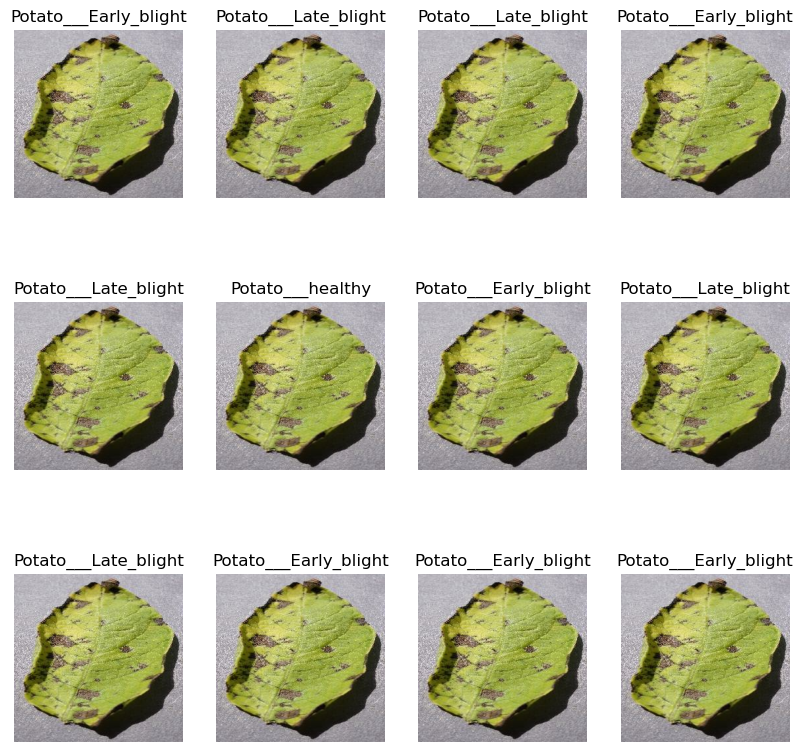

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range (12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

80% ==> training
20% ==> 10% validation, 10% test

In [68]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [69]:
train_ds= dataset.take(54)
len(train_ds)

54

In [70]:
train_ds = dataset.skip(54)
len(train_ds)

14

In [71]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [72]:
val_ds = train_ds.take(6)
len(val_ds)

6

In [73]:
test_ds = train_ds.skip(6)
len(test_ds)

8

In [74]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds= ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [75]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [76]:
len(train_ds)

54

In [77]:
len(val_ds)

6

In [78]:
len(test_ds)

8

In [79]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [80]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [81]:
data_augmentation = tf.keras.Sequential ([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [82]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu' ,input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [83]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_12 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_50 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

In [45]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [48]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 231s 4s/step - loss: 0.0482 - accuracy: 0.9803 - val_loss: 0.1452 - val_accuracy: 0.9375
Epoch 2/50
54/54 [==============================] - 232s 4s/step - loss: 0.0356 - accuracy: 0.9884 - val_loss: 0.0358 - val_accuracy: 0.9792
Epoch 3/50
54/54 [==============================] - 232s 4s/step - loss: 0.0184 - accuracy: 0.9942 - val_loss: 0.0257 - val_accuracy: 0.9792
Epoch 4/50
54/54 [==============================] - 220s 4s/step - loss: 0.0317 - accuracy: 0.9896 - val_loss: 0.4004 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 232s 4s/step - loss: 0.0442 - accuracy: 0.9844 - val_loss: 0.0274 - val_accuracy: 0.9896
Epoch 6/50
54/54 [==============================] - 236s 4s/step - loss: 0.0406 - accuracy: 0.9826 - val_loss: 0.0163 - val_accuracy: 0.9948
Epoch 7/50
54/54 [==============================] - 248s 5s/step - loss: 0.0225 - accuracy: 0.9954 - val_loss: 0.0339 - val_accuracy: 0.9792
Epoch 8/50
54

scores = model.evaluate(test_ds)

In [50]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 21s 2s/step - loss: 0.0132 - accuracy: 0.9961


In [51]:
scores

[0.013186061754822731, 0.99609375]

In [52]:
history

In [53]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [54]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

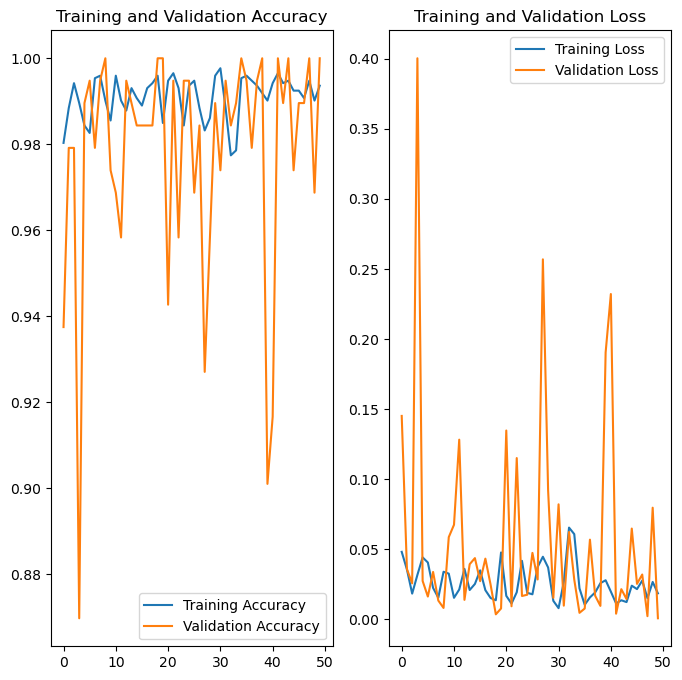

In [58]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()